## Synthetic Mixing Experiments

In [1]:
# use hydra configs to load the dataset
import hydra
from utils import hydra_custom_resolvers
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
configs_path = "configs"
# config_name = "train_root.yaml"
config_name = "train_root.yaml"

with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                "datamodule=mixing",
                                "datamodule.dataset.num_domains=10",
                                # "model=mixing"
                            ],
                            return_hydra_config=True,
    )

    # setup the dataset with the hydra config
    datamodule = hydra.utils.instantiate(config.datamodule, _recursive_=False)
    datamodule.prepare_data()
    datamodule.setup()

    # instantiate the model with hydra
    # model = hydra.utils.instantiate(config.model, _recursive_=False)

iterator = iter(datamodule.test_dataloader())

/home/mila/s/sayed.mansouri-tehrani/.conda/envs/bb/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
z_dim_invariant_data = datamodule.train_dataset.dataset.z_dim_invariant
z_dim = datamodule.train_dataset.dataset.z_dim

In [3]:
batch = next(iterator)

In [4]:
batch["z"][(batch["domain"] == 1).squeeze(), :z_dim_invariant_data].min()

tensor(0.0984)

In [11]:
for domain_idx in range(datamodule.train_dataset.dataset.num_domains):
    print(f"domain:{domain_idx} -- min:{batch['z'][(batch['domain'] == domain_idx).squeeze(), :z_dim_invariant_data].min()}, max:{batch['z'][(batch['domain'] == domain_idx).squeeze(), :z_dim_invariant_data].max()}, mean:{batch['z'][(batch['domain'] == domain_idx).squeeze(), :z_dim_invariant_data].mean()}")
print("----------------")
for domain_idx in range(datamodule.train_dataset.dataset.num_domains):
    print(f"domain:{domain_idx} -- min:{batch['z'][(batch['domain'] == domain_idx).squeeze(), z_dim_invariant_data:].min()}, max:{batch['z'][(batch['domain'] == domain_idx).squeeze(), z_dim_invariant_data:].max()}, mean:{batch['z'][(batch['domain'] == domain_idx).squeeze(), z_dim_invariant_data:].mean()}")
print("----------------")
for domain_idx in range(datamodule.train_dataset.dataset.num_domains):
    for z_dim_spurious in range(z_dim_invariant_data, z_dim):
        print(f"domain:{domain_idx}, z_dim:{z_dim_spurious} -- min:{batch['z'][(batch['domain'] == domain_idx).squeeze(), z_dim_spurious].min()}, max:{batch['z'][(batch['domain'] == domain_idx).squeeze(), z_dim_spurious].max()}, mean:{batch['z'][(batch['domain'] == domain_idx).squeeze(), z_dim_spurious].mean()}")

----------------
domain:0, z_dim:2 -- min:-3.395689010620117, max:-1.9791346788406372, mean:-2.710878849029541
domain:0, z_dim:3 -- min:-1.2148573398590088, max:-0.8057138919830322, mean:-1.0142569541931152
domain:1, z_dim:2 -- min:-4.767006874084473, max:-2.539933681488037, mean:-3.676292896270752
domain:1, z_dim:3 -- min:-4.0764007568359375, max:-0.9848365783691406, mean:-2.4427056312561035
domain:2, z_dim:2 -- min:-1.7045924663543701, max:-0.3207516670227051, mean:-0.9372190237045288
domain:2, z_dim:3 -- min:1.9994860887527466, max:2.109677791595459, mean:2.0614607334136963
domain:3, z_dim:2 -- min:3.3331382274627686, max:4.46589469909668, mean:3.8830065727233887
domain:3, z_dim:3 -- min:-2.0340495109558105, max:-0.48385369777679443, mean:-1.1251734495162964
domain:4, z_dim:2 -- min:-2.998680353164673, max:-1.8430469036102295, mean:-2.490309715270996
domain:4, z_dim:3 -- min:-4.002238750457764, max:-3.2039177417755127, mean:-3.526283025741577
domain:5, z_dim:2 -- min:-4.054628849029

## Coloured MNIST Experiments

In [1]:
# golden standard
import numpy as np
import os
import math
import torch
import torchvision
from torchvision import transforms



# laod MNIST
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
root = "/network/datasets/torchvision"
data = torchvision.datasets.MNIST(root, True, transform=transform)

# color it

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data[0][0].permute(1,2,0).repeat(1, 1, 3), cmap='gray')

In [2]:
# use hydra configs to load the dataset
import hydra
from utils import hydra_custom_resolvers
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
configs_path = "configs"
# config_name = "train_root.yaml"
config_name = "evaluate_root.yaml"

with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                # "datamodule/dataset=mnist",
                                "datamodule/dataset=multi_domain_mnist",
                                "datamodule.dataset.num_domains=8",
                                # "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_32-epoch=52-val_loss=0.01.ckpt'",
                                # "model.autoencoder.num_channels=3",
                            ],
                            return_hydra_config=True,
    )

    transform = transforms.Compose([hydra.utils.instantiate(t) for _, t in config.datamodule.transforms.items()])
    def renormalize():
        for _, t in config.datamodule.transforms.items():
            if "Standardize" in t["_target_"]:
                """Renormalize from [-1, 1] to [0, 1]."""
                return lambda x: x / 2.0 + 0.5
            
    # setup the dataset with the hydra config
    datamodule = hydra.utils.instantiate(config.datamodule, _recursive_=False)
    datamodule.prepare_data()
    datamodule.setup()

    # instantiate the model with hydra
    # model = hydra.utils.instantiate(config.model, _recursive_=False)

# renormalize = datamodule.train_dataset.dataset.renormalize()
iterator = iter(datamodule.test_dataloader())

min, max: 0.0, 0.9963283538818359
min, max: 0.0, 0.988601803779602


/home/mila/s/sayed.mansouri-tehrani/.conda/envs/bb/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
# use hydra configs to load the dataset
import hydra
from utils import hydra_custom_resolvers
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
configs_path = "configs"
# config_name = "train_root.yaml"
config_name = "evaluate_root.yaml"

with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                # "datamodule/dataset=mnist",
                                # "datamodule/dataset=multi_domain_mnist",
                                # if using a ckpt MAKE SURE TO USE EVALUATE CONFIG AND NOT TRAIN ^^^^
                                # "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_32-epoch=52-val_loss=0.01.ckpt'",
                                "model.autoencoder.num_channels=3",
                                "+model.z_dim=256",
                                # "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_8_256-epoch=18-val_loss=0.01-val_r2_hz_z=0.00-val_r2_~hz_z=0.00-v6.ckpt'",
                                # working ckpt for both digits and colours
                                "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_8_256-epoch=36-val_loss=0.00-val_r2_hz_z=0.00-val_r2_~hz_z=0.00-v4.ckpt'",
                                # "model.autoencoder.num_channels=3",
                            ],
                            return_hydra_config=True,
    )

    # instantiate the model with hydra
    model = hydra.utils.instantiate(config.model, _recursive_=False)


In [5]:
# m = torch.load("/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_32-epoch=52-val_loss=0.01.ckpt")
# m = torch.load("/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_64-epoch=23-val_loss=0.01-val_r2_hz_z=0.00-val_r2_~hz_z=0.00-v4.ckpt")
m = torch.load("/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_8_256-epoch=36-val_loss=0.00-val_r2_hz_z=0.00-val_r2_~hz_z=0.00-v4.ckpt")

In [6]:
for key in model.state_dict().keys():
    print((model.state_dict()[key] == m["state_dict"][key].to('cpu')).all())

tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)


In [ ]:
model.model.hparams

"decoder_fc":   {'_target_': 'models.modules.fc_ae.Decoder', 'latent_size': 32, 'width': 28, 'height': 28, 'num_channels': 3, 'decoder_layers': {'Linear1': {'_target_': 'torch.nn.Linear', 'in_features': 32, 'out_features': 64}, 'LeakyReLU1': {'_target_': 'torch.nn.LeakyReLU'}, 'Dropout1': {'_target_': 'torch.nn.Dropout', 'p': 0.5}, 'Linear2': {'_target_': 'torch.nn.Linear', 'in_features': 64, 'out_features': 128}, 'LeakyReLU2': {'_target_': 'torch.nn.LeakyReLU'}, 'Dropout2': {'_target_': 'torch.nn.Dropout', 'p': 0.5}, 'Linear3': {'_target_': 'torch.nn.Linear', 'in_features': 128, 'out_features': 256}, 'LeakyReLU3': {'_target_': 'torch.nn.LeakyReLU'}, 'Dropout3': {'_target_': 'torch.nn.Dropout', 'p': 0.5}, 'Linear4': {'_target_': 'torch.nn.Linear', 'in_features': 256, 'out_features': 512}, 'LeakyReLU4': {'_target_': 'torch.nn.LeakyReLU'}, 'Dropout4': {'_target_': 'torch.nn.Dropout', 'p': 0.5}, 'Linear5': {'_target_': 'torch.nn.Linear', 'in_features': 512, 'out_features': 2352}, 'LeakyRe

In [7]:
batch = next(iterator)
img, labels = batch["image"], batch["label"]
# img, labels, domains, colors = batch["image"], batch["label"], batch["domain"], batch["color"]

In [8]:
img[0].std()
# normalize the image such that it has a std of 1 and mean of 0


tensor(0.1698)

In [9]:
model(img)[0].shape

torch.Size([256, 256])

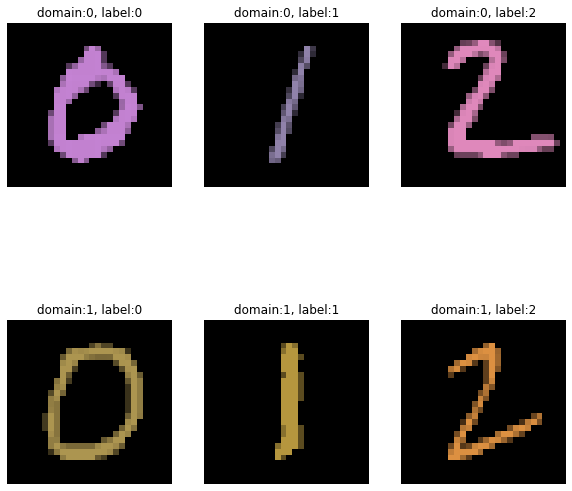

In [4]:
# plot 3 images from each domain
fig, axs = plt.subplots(datamodule.train_dataset.dataset.num_domains, 3, figsize=(10, 10))
for domain_idx in range(datamodule.train_dataset.dataset.num_domains):
    for img_idx in range(3):
        axs[domain_idx, img_idx].imshow(img[(labels == img_idx) & (batch["domain"] == domain_idx)][0].permute(1,2,0))
        axs[domain_idx, img_idx].set_title(f"domain:{domain_idx}, label:{img_idx}")
        axs[domain_idx, img_idx].axis("off")

In [10]:
z, recons = model.model(img)

In [ ]:
domain_z_mins = torch.zeros((2, 16, 5))
domain_z_maxs = torch.zeros((2, 16, 5))

# z is [batch_size, latent_dim], so is domains. For the first d dimensions
# of z, find the top_k smallest values of that dimension in each domain
# find the mask of z's for each domain
# for each domain, and for each of the first d dimensions, 
# find the top_k smallest values of that z dimension in that domain
for domain_idx in range(2):
    domain_mask = (domains == domain_idx).squeeze()
    domain_z = z[domain_mask]
    # for each dimension i among the first d dimensions of z, find the top_k
    # smallest values of dimension i in domain_z
    for i in range(16):
        domain_z_sorted, _ = torch.sort(domain_z[:, i], dim=0)
        domain_z_sorted = domain_z_sorted.squeeze()
        domain_z_sorted = domain_z_sorted[:5]
        domain_z_mins[domain_idx, i, :] = domain_z_sorted
        # find the top_k largest values of dimension i in domain_z
        domain_z_sorted, _ = torch.sort(domain_z[:, i], dim=0, descending=True)
        domain_z_sorted = domain_z_sorted.squeeze()
        domain_z_sorted = domain_z_sorted[:5]
        domain_z_maxs[domain_idx, i, :] = domain_z_sorted

mse_mins = F.mse_loss(domain_z_mins[0], domain_z_mins[1], reduction="mean")
mse_maxs = F.mse_loss(domain_z_maxs[0], domain_z_maxs[1], reduction="mean")


In [ ]:
# print(domain_z_mins[0])
# print(domain_z_mins[1])
# print(domain_z_maxs[0])
# print(domain_z_maxs[1])
mse_mins = F.mse_loss(domain_z_mins[0], domain_z_mins[1], reduction="sum")
print(mse_mins)

tensor(0.4542, grad_fn=<MseLossBackward0>)


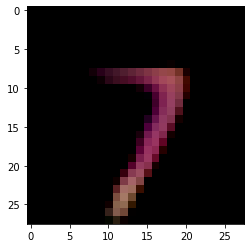

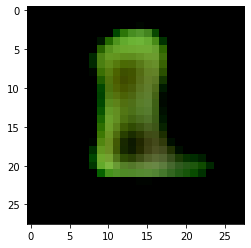

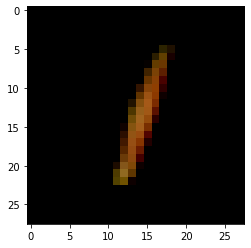

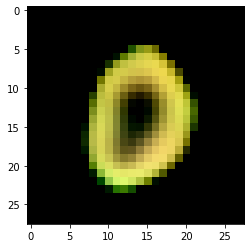

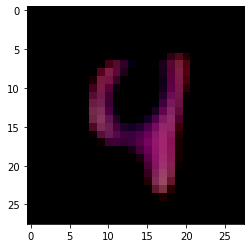

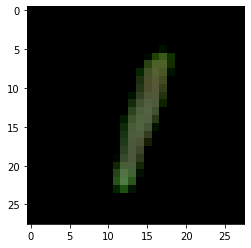

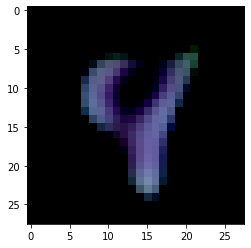

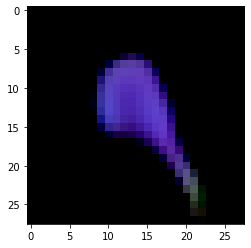

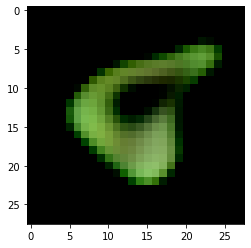

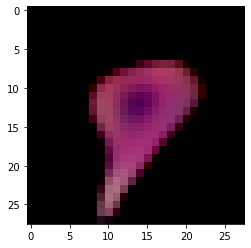

In [11]:
import matplotlib.pyplot as plt

# a function to clamps the values of a numpy array between 0,1
def clamp(x):
    return np.minimum(np.maximum(x, 0), 1)

for i in range(10):
    plt.figure()
    plt.imshow(clamp(recons[i].permute(1,2,0).detach().cpu().numpy()))

In [ ]:
# iterator = iter(datamodule.train_dataloader())
iterator = iter(datamodule.test_dataloader())
# iterator = iter(datamodule.val_dataloader())
print(next(iterator)["image"].shape)
import matplotlib.pyplot as plt
for i in range(20,40):
    sample = next(iterator)
    sample_img, sample_label, sample_domain, sample_color = sample["image"][i], sample["label"][i], sample["domain"][i], sample["color"][i]
    print(f"sample_label: {sample_label}, sample_domain: {sample_domain}, sample_color: {sample_color}")
    plt.figure()
    plt.imshow(sample_img.permute(1,2,0))
    z, recons = model.model(sample_img.unsqueeze(0))
    plt.figure()
    plt.imshow(recons[0].permute(1,2,0).detach().cpu().numpy())

In [21]:
print(f"min and max and mean of sample image: {sample_img.unsqueeze(0).min()}, {sample_img.unsqueeze(0).max()}, {sample_img.unsqueeze(0).mean()}")
print(f"min and max and mean of recon image: {recons[0].min()}, {recons[0].max()}, {recons[0].mean()}")

NameError: name 'sample_img' is not defined

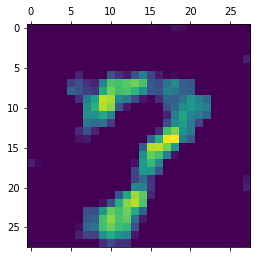

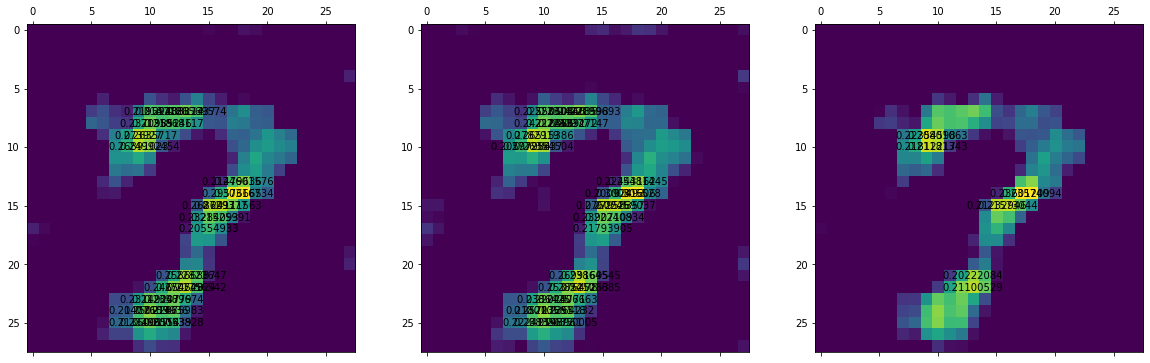

In [14]:
plt.matshow(recons[0].permute(1,2,0)[:, :, 0].detach().cpu().numpy())
# create a subplot to show the RGB channels separately. Use matshow and inside the matshow show the value of each pixel
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
# show the RGB channels separately and inside the shown matrix matshow to show the values of a tensor, and also put the numerical values of the tensor in the corresponding pixels of the resulting plot
for channel in range(3):
    ax[channel].matshow(recons[0].permute(1,2,0)[:, :, channel].detach().cpu().numpy())
    for i in range(recons[0].shape[1]):
        for j in range(recons[0].shape[2]):
            if recons[0][channel, i, j] > 0.2:
                # show the value only to two decimals
                ax[channel].text(j, i, str(recons[0].permute(1,2,0)[i, j, channel].detach().cpu().numpy()), va='center', ha='center', color='black')



In [20]:
recons[0][:, 8:12, 8:12].permute(1,2,0)

tensor([[[0.0469, 0.0631, 0.0140],
         [0.1848, 0.1869, 0.1391],
         [0.2371, 0.2421, 0.1814],
         [0.2136, 0.2224, 0.1669]],

        [[0.1754, 0.1858, 0.1324],
         [0.2739, 0.2783, 0.2235],
         [0.2636, 0.2652, 0.2080],
         [0.1438, 0.1536, 0.1075]],

        [[0.1963, 0.2060, 0.1460],
         [0.2689, 0.2773, 0.2181],
         [0.2499, 0.2635, 0.2118],
         [0.0827, 0.0802, 0.0394]],

        [[0.1530, 0.1651, 0.1073],
         [0.1824, 0.1903, 0.1340],
         [0.1387, 0.1575, 0.0975],
         [0.0000, 0.0000, 0.0000]]], grad_fn=<PermuteBackward0>)

In [17]:
model

AutoencoderPL(
  (model): CNNAE(
    (encoder_cnn): Encoder(
      (layers): Sequential(
        (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): ReLU()
        (6): Conv2d(16, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): ReLU()
      )
    )
    (decoder_cnn): Decoder(
      (layers): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): ConvTranspose2d(16, 8, kernel_size=

## MNIST Experiments with Encoded Images

In [2]:
# use hydra configs to load the dataset
import hydra
from utils import hydra_custom_resolvers
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
configs_path = "configs"
# config_name = "train_root.yaml"
config_name = "train_root.yaml"

with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                "datamodule=mnist_encoded",
                                "run_path='/home/mila/s/sayed.mansouri-tehrani/scratch/logs/training/runs/autoencoder_multi_domain_mnist_8_256/2023-09-09_04-37-16'",
                            ],
                            return_hydra_config=True,
    )

    # setup the dataset with the hydra config
    datamodule = hydra.utils.instantiate(config.datamodule, _recursive_=False)
    datamodule.prepare_data()
    datamodule.setup()

    # instantiate the model with hydra
    # model = hydra.utils.instantiate(config.model, _recursive_=False)

# renormalize = datamodule.train_dataset.dataset.renormalize()
iterator = iter(datamodule.test_dataloader())

/home/mila/s/sayed.mansouri-tehrani/.conda/envs/bb/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [1]:
datamodule.train_dataset[0]["x"].shape
iterator = iter(datamodule.train_dataloader())
batch = next(iterator)
x, label, domain, color = batch["x"], batch["label"], batch["domain"], batch["color"]
print(batch["x"].shape, batch["label"].shape, batch["domain"].shape, batch["color"].shape)

NameError: name 'datamodule' is not defined

In [6]:
datamodule.valid_dataset.__len__()

60000

In [ ]:
# use hydra configs to load the dataset
import hydra
from utils import hydra_custom_resolvers
import torch
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
configs_path = "configs"
# config_name = "train_root.yaml"
config_name = "evaluate_root.yaml"

with hydra.initialize(config_path=configs_path):
    config = hydra.compose(config_name=config_name,
                            overrides=[
                                # "datamodule/dataset=mnist",
                                # "datamodule/dataset=multi_domain_mnist",
                                # if using a ckpt MAKE SURE TO USE EVALUATE CONFIG AND NOT TRAIN ^^^^
                                # "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_32-epoch=52-val_loss=0.01.ckpt'",
                                "model.autoencoder.num_channels=3",
                                "+model.z_dim=256",
                                # "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_8_256-epoch=18-val_loss=0.01-val_r2_hz_z=0.00-val_r2_~hz_z=0.00-v6.ckpt'",
                                # working ckpt for both digits and colours
                                "+ckpt_path='/home/mila/s/sayed.mansouri-tehrani/MD-CRL/autoencoder_multi_domain_mnist_8_256-epoch=36-val_loss=0.00-val_r2_hz_z=0.00-val_r2_~hz_z=0.00-v4.ckpt'",
                                # "model.autoencoder.num_channels=3",
                            ],
                            return_hydra_config=True,
    )

    # instantiate the model with hydra
    model = hydra.utils.instantiate(config.model, _recursive_=False)
